In [157]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import pandas_datareader as pdr
import hvplot.pandas
import matplotlib.pyplot as plt
import pyEX as p
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import svm



In [96]:
# Select start and end dates
start_date = pd.Timestamp('2017-10-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-10-01', tz='America/New_York').isoformat()



In [97]:
# Import the Yahoo Finance dataset into a Pandas Dataframe, in this case JP Morgan.
# We only need the date and the adjusted closing price. 
jpm_df = pdr.DataReader('JPM','yahoo',start_date,end_date)['Adj Close']


jpm_df.head()

Date
2017-10-02    85.915306
2017-10-03    86.367760
2017-10-04    85.489464
2017-10-05    86.640633
2017-10-06    86.488930
Name: Adj Close, dtype: float64

In [98]:
# Make the MACD and the signal line
exp1 = jpm_df.ewm(span=12, adjust=False).mean()
exp2 = jpm_df.ewm(span=26, adjust=False).mean()
macd = exp1 - exp2

exp3 = macd.ewm(span=9, adjust=False).mean()

In [99]:
#Change column names 
macd.head()
macd.rename("MACD")

Date
2017-10-02    0.000000
2017-10-03    0.036093
2017-10-04   -0.006104
2017-10-05    0.052737
2017-10-06    0.086135
                ...   
2021-09-27    0.980370
2021-09-28    1.419394
2021-09-29    1.736874
2021-09-30    1.786614
2021-10-01    2.077996
Name: MACD, Length: 1008, dtype: float64

In [100]:
exp3.rename("Signal")

Date
2017-10-02    0.000000
2017-10-03    0.007219
2017-10-04    0.004554
2017-10-05    0.014191
2017-10-06    0.028580
                ...   
2021-09-27    0.314303
2021-09-28    0.535321
2021-09-29    0.775632
2021-09-30    0.977828
2021-10-01    1.197862
Name: Signal, Length: 1008, dtype: float64

<AxesSubplot:>

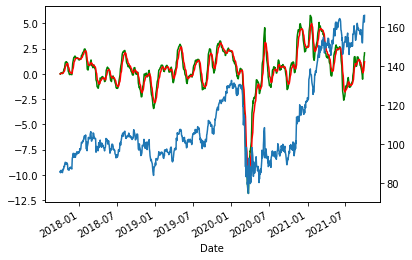

In [101]:
# Plot

macd.plot(label='JPM MACD', color='g')
ax = exp3.plot(label='Signal Line', color='r')
jpm_df.plot(ax=ax, secondary_y=True, label='')

In [102]:
# hvPlot 

macd.hvplot.line()
exp3.hvplot.line()

:Curve   [Date]   (Adj Close)

In [103]:
jpm = pd.concat([jpm_df,macd,exp3], axis=1)

jpm.columns = ['Adj Close', 'MACD', 'Signal Line']

jpm.head()

,Adj Close,MACD,Signal Line
Date,,,
2017-10-02,85.915306,0.000000,0.000000
2017-10-03,86.367760,0.036093,0.007219
2017-10-04,85.489464,-0.006104,0.004554
2017-10-05,86.640633,0.052737,0.014191
2017-10-06,86.488930,0.086135,0.028580


In [104]:
jpm.hvplot.line()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

## Create the model


In [105]:
#Add a trade type column to the dataframe

jpm['trade type'] = np.nan
jpm['trade type'] = jpm['trade type'].astype(str)
jpm.head()

,Adj Close,MACD,Signal Line,trade type
Date,,,,
2017-10-02,85.915306,0.000000,0.000000,nan
2017-10-03,86.367760,0.036093,0.007219,nan
2017-10-04,85.489464,-0.006104,0.004554,nan
2017-10-05,86.640633,0.052737,0.014191,nan
2017-10-06,86.488930,0.086135,0.028580,nan


In [106]:

jpm.drop(['trade_type'], axis=1)

KeyError: "['trade_type'] not found in axis"

In [ ]:
#Trading strategy, buy when the MACD signal line moves from negative. Sell vice versa.

jpm['lag'] = np.nan
jpm.head()

jpm.drop(['trade_type'], axis=1)

In [107]:
jpm['lag'] = jpm['Signal Line'].shift()

In [108]:
jpm.head()

,Adj Close,MACD,Signal Line,trade type,lag
Date,,,,,
2017-10-02,85.915306,0.000000,0.000000,nan,NaN
2017-10-03,86.367760,0.036093,0.007219,nan,0.000000
2017-10-04,85.489464,-0.006104,0.004554,nan,0.007219
2017-10-05,86.640633,0.052737,0.014191,nan,0.004554
2017-10-06,86.488930,0.086135,0.028580,nan,0.014191


In [109]:
for index, row in jpm.iterrows():
    if row['Signal Line'] > 0 and row['lag'] < 0:
        jpm.at[index,'trade type'] = 'Buy'
    elif row['Signal Line']<0 and row['lag']>0:
        jpm.at[index,'trade type'] = 'Sell'
    else:
        jpm.at[index,'trade type'] = 'Hold'

In [110]:
jpm.head()

,Adj Close,MACD,Signal Line,trade type,lag
Date,,,,,
2017-10-02,85.915306,0.000000,0.000000,Hold,NaN
2017-10-03,86.367760,0.036093,0.007219,Hold,0.000000
2017-10-04,85.489464,-0.006104,0.004554,Hold,0.007219
2017-10-05,86.640633,0.052737,0.014191,Hold,0.004554
2017-10-06,86.488930,0.086135,0.028580,Hold,0.014191


SyntaxError: invalid syntax (<ipython-input-111-2055b08c9eae>, line 1)

In [116]:
jpm['trade type'].value_counts()

Hold    984
Sell     12
Buy      12
Name: trade type, dtype: int64

In [168]:
#Alternative method for scaling and training ect.

X = jpm[['Adj Close', 'MACD','Signal Line', 'lag']].shift().dropna().copy()

jpm['signal'] = 0.0
jpm.loc[(jpm['trade type'] == 'Buy'), 'signal'] = 1
jpm.loc[(jpm['trade type'] == 'Sell'), 'signal'] = -1
jpm.loc[(jpm['trade type'] == 'Hold'), 'signal'] = 0

y = jpm['signal'].copy()

# Select the start of the training period
training_begin = X.index.min()

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(years=3)


In [169]:
training_end

Timestamp('2020-10-04 00:00:00')

In [170]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,Adj Close,MACD,Signal Line,lag
Date,,,,
2017-10-04,86.367760,0.036093,0.007219,0.000000
2017-10-05,85.489464,-0.006104,0.004554,0.007219
2017-10-06,86.640633,0.052737,0.014191,0.004554
2017-10-09,86.488930,0.086135,0.028580,0.014191
2017-10-10,86.033821,0.075014,0.037866,0.028580


In [171]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,Adj Close,MACD,Signal Line,lag
Date,,,,
2020-10-05,94.614021,-0.942572,-1.018141,-1.037033
2020-10-06,96.613800,-0.609279,-0.936368,-1.018141
2020-10-07,95.618790,-0.420582,-0.833211,-0.936368
2020-10-08,97.286903,-0.134881,-0.693545,-0.833211
2020-10-09,99.286682,0.250023,-0.504831,-0.693545


In [172]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X_train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [173]:
y_train.value_counts()

 0.0    734
-1.0     11
 1.0     10
Name: signal, dtype: int64

In [174]:

# Create the classifier model
svm_model = svm.SVC()

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [175]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        11
         0.0       0.97      1.00      0.99       734
         1.0       0.00      0.00      0.00        10

    accuracy                           0.97       755
   macro avg       0.32      0.33      0.33       755
weighted avg       0.95      0.97      0.96       755



/Users/edwardfoote/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edwardfoote/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edwardfoote/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
